In [81]:
import mne

In [82]:
filename = '1_raw.fif'

In [83]:
raw = mne.io.read_raw_fif(filename, preload=True)
raw.pick_types(eeg=True)
raw.set_eeg_reference('average', projection=True)
raw.filter(1., 50.)

<Raw | 1_raw.fif, 32 x 14002 (56.0 s), ~3.5 MiB, data loaded>

In [84]:
annotations = raw.annotations
times = annotations.onset
descriptions = annotations.description

In [85]:
epoch = raw.copy().crop(tmin=0, tmax=1)

In [86]:
epoch
data, _ = epoch[:]
n_samples = epoch.n_times

In [87]:
psds, freqs = mne.time_frequency.psd_array_welch(
                        data, sfreq=raw.info['sfreq'], fmin=0.5, fmax=100, n_fft=n_samples
                    )

In [88]:
events, event_id = mne.events_from_annotations(raw)

In [89]:
epochs = mne.Epochs(
                raw, events, event_id=None, tmin=-0.2, tmax=1.0,
                baseline=(None, 0), preload=True, event_repeated='drop'
            )
evoked = epochs.average()


In [90]:
evoked

<Evoked | '0.14 × 1 + 0.14 × 3 + 0.14 × 4 + 0.29 × 5 + 0.29 × 6' (average, N=7), -0.2 – 1 s, baseline -0.2 – 0 s, 32 ch, ~121 KiB>

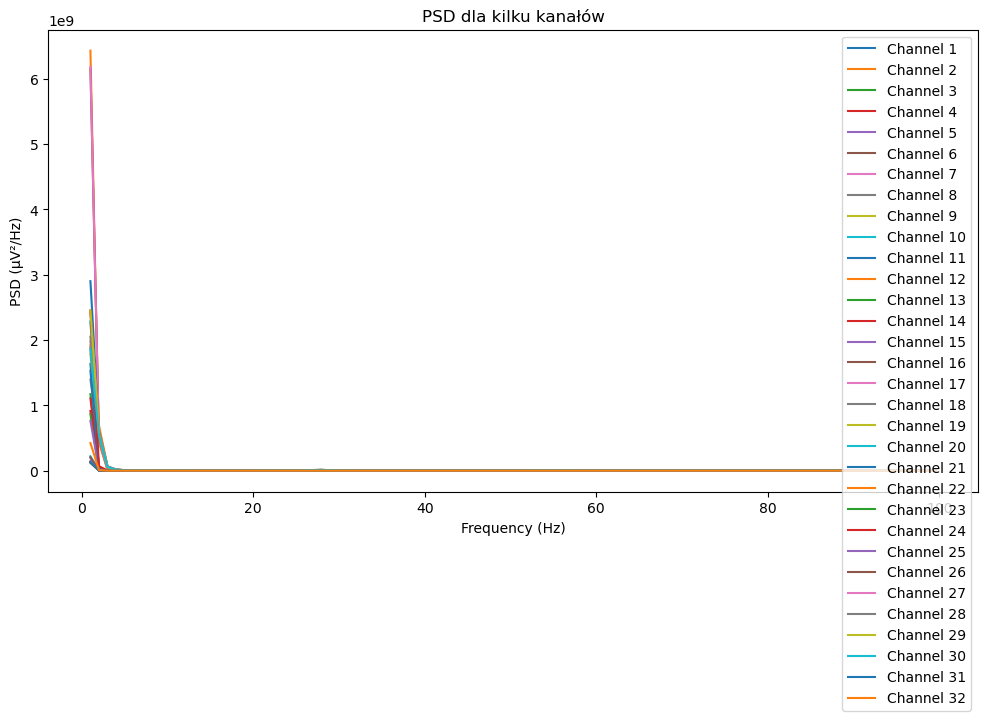

In [91]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
for i in range(32):
    plt.plot(freqs, psds[i, :], label=f'Channel {i+1}')
plt.xlabel('Frequency (Hz)')
plt.ylabel('PSD (µV²/Hz)')
plt.title('PSD dla kilku kanałów')
plt.legend()
plt.show()


In [92]:
import numpy as np

bands = {'Delta': (0.5, 4),
         'Theta': (4, 8),
         'Alpha': (8, 12),
         'Beta': (12, 30),
         'Gamma': (30, 100)}

band_power = np.zeros((32, len(bands)))
for j, (band, (low, high)) in enumerate(bands.items()):
    idx = np.logical_and(freqs >= low, freqs <= high)
    band_power[:, j] = psds[:, idx].mean(axis=1)

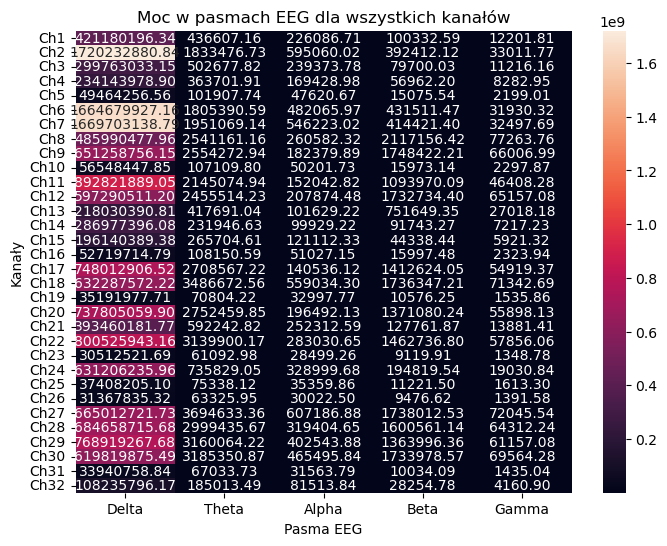

In [93]:
import seaborn as sns

plt.figure(figsize=(8,6))
sns.heatmap(band_power, annot=True, fmt=".2f", 
            yticklabels=[f'Ch{i+1}' for i in range(32)], 
            xticklabels=list(bands.keys()))
plt.xlabel('Pasma EEG')
plt.ylabel('Kanały')
plt.title('Moc w pasmach EEG dla wszystkich kanałów')
plt.show()


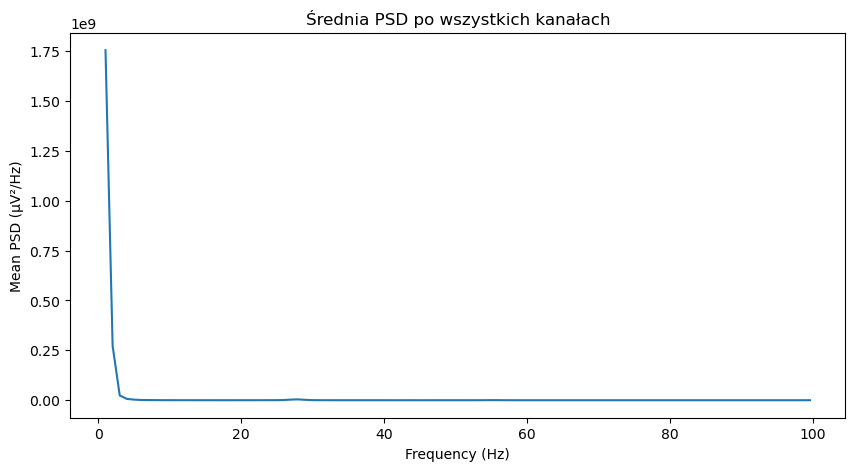

In [94]:
mean_psd = psds.mean(axis=0)
plt.figure(figsize=(10,5))
plt.plot(freqs, mean_psd)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Mean PSD (µV²/Hz)')
plt.title('Średnia PSD po wszystkich kanałach')
plt.show()